# Engineering optical forces through Maxwell Stress Tensor inverse design: forces on a square particle

This notebook explains how to calculate fields and forces on a square particle under plane-wave illumination. 

In [1]:
import sys
import os 

relative_path = "./../src/"
absolute_path = os.path.abspath(relative_path)

if absolute_path not in sys.path:
    sys.path.append(absolute_path)

In [2]:
import numpy as np
from solver import freq_top_opt_2D

## Simulation parameters

### Geometric parameters:

We start with some general geometric variables for the mesh:

In [3]:
r = 1 # mesh refinement factor: the larger the refinement factor, the finer the mesh.
scaling =  20e-9/r # the scale applied to the physical problem, all geometric values are given in units of this scaling.
fR = int(2*r) # value for the filtering radius   
nElx = int(r*200) + 2*fR # the number of elements in the X axis
nEly = int(r*100) + 2*fR # the number of elements in the Y axis\

Now we set the variables for the design region for the lens. Since we will just optimize the particle in this example, we set the initial guess to zero.

In [4]:
thickness = int(r*10) # the thickness of the design region for the lens, in number of elements in the Y direction
limit = int(np.floor((nEly-2*fR)*9/10))+fR # the lower limit of the design region, 0.9 * total height of the simulation volume
dVElmIdx = np.array([np.arange(limit-thickness,limit),np.arange(fR,nElx-fR)])  # the indexes of the domain of the  design variables
DVini = 0.0 * np.ones(len(dVElmIdx[0])*len(dVElmIdx[1])) # the initial value / guess for the design parameters

/tmp/ipykernel_433900/1213506299.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dVElmIdx = np.array([np.arange(limit-thickness,limit),np.arange(fR,nElx-fR)])  # the indexes of the domain of the  design variables


Now we do the same for the geometric variables for the particle:

In [5]:
center = [int(r*100)+ fR, int(r*40)+ fR] # the index for the geometric center of the particle
width_part = int(r*35) # the width of the particle
height_part = int(r*35) # the height of the particle
dVElmIdx_part = np.array([np.arange(center[1]-height_part//2,center[1]+height_part//2),np.arange(center[0]-width_part//2,center[0]+width_part//2)])  # the indexes of the domain of the  design variables
dVElmIdx_part_pad = np.array([np.arange(center[1]-height_part//2-fR,center[1]+height_part//2+fR),np.arange(center[0]-width_part//2-fR,center[0]+width_part//2+fR)])  # a padded (pad: fR) version of the indexes of the domain of the  design variables
DVini_part = 1 * np.ones(len(dVElmIdx_part[0])*len(dVElmIdx_part[1])) # the initial value / guess for the design parameters
part_shape = "square" # shape of the particle, can be chosen to be a square or a cirlce too.
part_size = int(r*35) # the size of the particle, only necessary for square or circle particles.

### Material parameters:

In [6]:
eps = 4      # value of the dielectric function for the metalens
eps_part = 4 # value of the dielectric function of the particle

### Physical parameters:

In [7]:
wl = int(r*35)  # value for the wavelentgth, i.e. 35*20nm=700 nm.

### Optimization parameters:

In [8]:
eta = 0.5
beta = 5

## Solving the forward problem for initial design:

### Initializing solver:

In [9]:
solver = freq_top_opt_2D( center,
                          dVElmIdx,
                          dVElmIdx_part,
                          dVElmIdx_part_pad,
                          nElx, 
                          nEly,
                          DVini,
                          DVini_part,  
                          eps, 
                          wl,  
                          fR,
                          eta, 
                          beta,
                          scaling,
                          part_shape,
                          part_size,
                          eps_part
                        )

FOM:  (17804319343374.195+0j)
Elapsed time in iteration: 0 min 4 s
----------------------------------------------


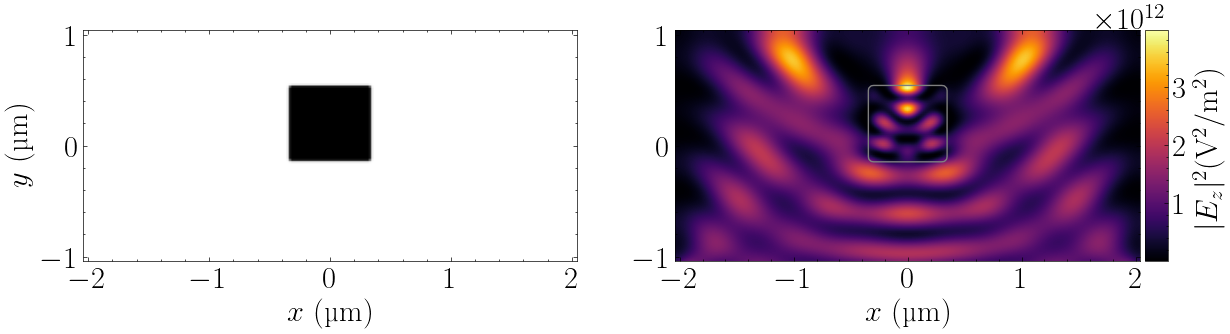

In [10]:
Ez, FOM = solver.solve_forward(DVini, DVini_part)

By solving the forward problem, we obtain the design of the particle and the electric field intensity.

To plot the real part of the electric field component:

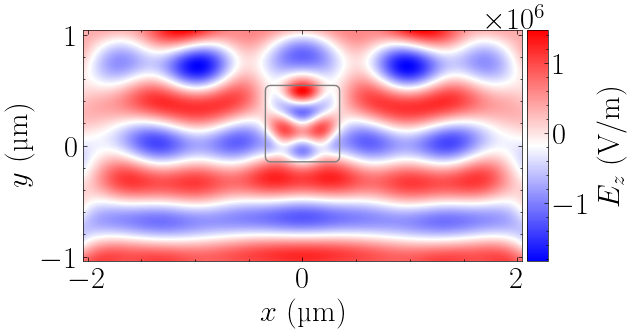

In [11]:
solver.plot_E_field()

We can also plot the real part of the magnetic field components:

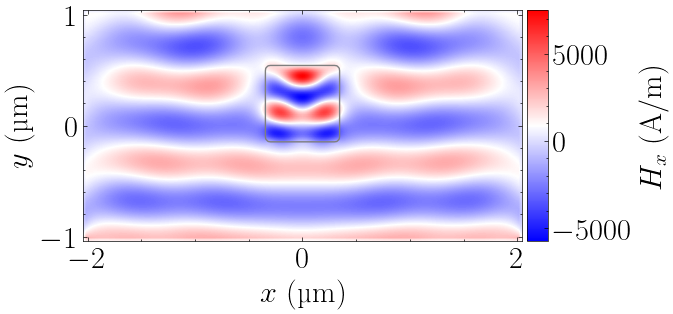

In [12]:
solver.plot_H_field(comp="x")

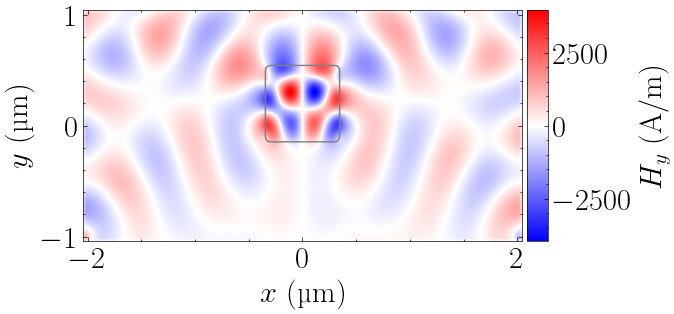

In [13]:
solver.plot_H_field(comp="y")

## Force calculation

Using the expression of the Maxwell Stress Tensor (MST) and integrating around the particle we can calculate the force:

$\langle\mathbf{F}\rangle=\int_{\partial
        V}\langle\stackrel{\leftrightarrow}{\mathbf{T}}(\mathbf{r}, t)\rangle \cdot
    \mathbf{n}_{\partial V}(\mathbf{r}) \, \mathrm{d} a$

where $\partial V$ denotes any boundary enclosing the particle and $\mathbf{n}_{\partial V}$
denotes the unitary vector normal to that boundary.

Remember that for TE polarization the expression of the the MST is simplified to:

$
    \langle \stackrel{\leftrightarrow}{\mathbf{T}} (\mathbf{r}, t) \rangle
    = \frac{1}{2} \Re  \begin{bmatrix}
        -\varepsilon_0 E_z^2 /2 +\mu_0\left(H_x^2-H^2/ 2\right) & \varepsilon_0 \mu_0
        H_x H_y^*                                               & 0                                              \\
        \varepsilon_0 \mu_0 H_y H_x^*                           & - \varepsilon_0 E_z^2 /2 +\mu_0\left(H_y^2-H^2
        / 2\right)                                              & 0                                              \\
        0                                                       &
        0                                                       &
        \varepsilon_0 E_z^2 / 2 -\mu_0 H^2 / 2                                                                   \\
    \end{bmatrix}
$

where all the fields are availabe from the finite element calculation.

By using these fuctions to calculate the force, we obtain:

In [14]:
solver.calculate_forces()

Fx (pN/μm):  3.5837999234900054e-15
Fy (pN/μm):  2.670647901506129


This means that the square mainly experiences a positive upwards force, while the horizontal component of the force is negligible!